In [182]:

from xbbg import blp
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import timedelta

vector = ["EURUSD CURNCY", "GBPUSD CURNCY","AUDUSD CURNCY","USDJPY CURNCY","CO1 COMDTY", "TZT1 COMDTY", "USGG2Y INDEX",
          "USGG10Y INDEX", "ES1 INDEX", "SX5E INDEX", "GDBR2 INDEX",
         "GDBR10 INDEX", "USDZAR CURNCY", "USDCNH CURNCY", "XAUUSD CURNCY", "HG1 COMDTY", "UX1 INDEX"]
log_flag = [True, True, True, True, True, True, False, False, True, True, False, False, True, True, True, True, False]
end=datetime.date.today()
start=datetime.date.today()-timedelta(days = 180)

data = blp.bdh(vector, 'LAST_PRICE', start,end)
data = data.dropna()

for k in range(0, len(log_flag)):
            if log_flag[k] == True:
                data.iloc[:,k] = data.iloc[:,k].apply(lambda x: np.log(x)*100)

data = data-data.shift(1)
data.dropna(inplace = True)
cols = data.columns
rename = []
for element in cols:
    rename.append(element[0])
data.columns = rename
                
print(data)
#print(data.shift(1))

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['savefig.facecolor']='white'

            EURUSD CURNCY  GBPUSD CURNCY  AUDUSD CURNCY  USDJPY CURNCY  \
2022-06-28      -0.616028      -0.662606      -0.260229       0.500737   
2022-06-29      -0.734701      -0.493666      -0.406151       0.329997   
2022-06-30       0.401415       0.444409       0.333745      -0.638980   
2022-07-01      -0.669923      -0.683890      -1.297678      -0.376481   
2022-07-05      -1.431359      -1.231194      -0.176263       0.472221   
...                   ...            ...            ...            ...   
2022-12-16      -0.395965      -0.246650      -0.268898      -0.860126   
2022-12-19       0.198179       0.008231       0.224132       0.226683   
2022-12-20       0.160143       0.279468      -0.328898      -3.856940   
2022-12-21      -0.179000      -0.832480       0.433322       0.552634   
2022-12-22      -0.084902      -0.364843      -0.553190      -0.083078   

            CO1 COMDTY  TZT1 COMDTY  USGG2Y INDEX  USGG10Y INDEX  ES1 INDEX  \
2022-06-28    2.480069    -0.218

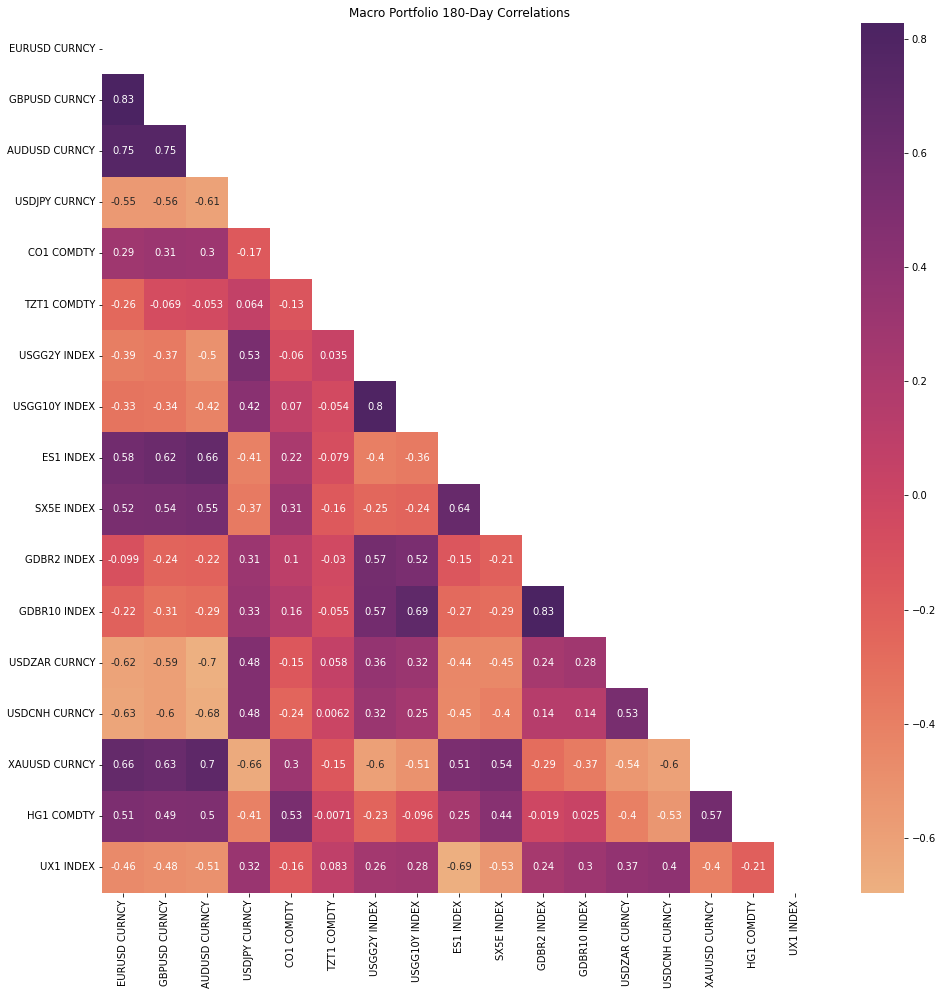

In [203]:
plt.figure(figsize=(16,16))
plt.title("Macro Portfolio 180-Day Correlations")

mask = np.triu(np.ones_like(data.corr(), dtype=bool))

sns.heatmap(data = data.corr(), mask = mask, annot = True, cmap = "flare")
plt.show()

In [298]:
def pca_rollingcorr(tickers, log_flags, window, lookback, cumulative):
    pc1_corr = []
    pc2_corr = []
    pc3_corr = []
    pc4_corr = []
    dates = []

    data_pull = blp.bdh(tickers, 'LAST_PRICE', datetime.date.today()-timedelta(days = window + lookback), datetime.date.today())
    cols = data_pull.columns
    rename = []
    for element in cols:
        rename.append(element[0])
    data_pull.columns = rename
    data_pull.dropna(inplace = True)
    
    
    for day_shift in range(0, lookback):
        end_date = datetime.date.today()-timedelta(days = day_shift)
        start_date = end_date-timedelta(days = window)
        vec = data_pull[(data_pull.index>=start_date) & (data_pull.index<=end_date)]
        #print(vec.iloc[:,0])
        for k in range(0, len(log_flags)):
            if log_flags[k] == True:
                vec.iloc[:,k] = vec.iloc[:,k].apply(lambda x: np.log(x)*100)

        vec = vec-vec.shift(1)
        vec.dropna(inplace = True)
        
        
        scaler = StandardScaler()
        vec_scaled = pd.DataFrame(scaler.fit_transform(vec), columns = vec.columns)
        
        
        n = vec_scaled.shape[1]
        pca = PCA(n_components = n, random_state = 1)
        
       
        
        pca_fitted = pca.fit_transform(vec_scaled)
        pca_dframe = pd.DataFrame(data = pca_fitted)
        
        exp_var = pca.explained_variance_ratio_
        pc1_corr.append(exp_var[0])
        pc2_corr.append(exp_var[1])
        pc3_corr.append(exp_var[2])
        pc4_corr.append(exp_var[3])
        dates.append(end_date)
        

    #print(dates, pc1_corr, pc2_corr)
    plt.figure(figsize = (12,12))
    plt.gca().set_facecolor("white")
    plt.title("Macro Portfolio PCA Dispersion\n%s-Day Sample, %s-Day Lookback"%(window, lookback))
    plt.xlabel("Date")
    plt.ylabel("Explained Variance Percentage")
    sns.lineplot(x = dates, y = pc1_corr, label = "Component_1", color = "Red")
    sns.lineplot(x = dates, y = pc2_corr, label = "Component_2", color = "Blue")
    sns.lineplot(x = dates, y = pc3_corr, label = "Component_3", color = "Green")
    sns.lineplot(x = dates, y = pc4_corr, label = "Component_4", color = "Orange")
    
    today = datetime.date.today()
    cumul_lookback = today - timedelta(days = cumulative)
    
    vec2 =  data_pull[(data_pull.index>=cumul_lookback) & (data_pull.index<=today)]
    scaler2 = StandardScaler()
    vec2_scaled = pd.DataFrame(scaler2.fit_transform(vec2), columns = vec2.columns)
    q = vec2_scaled.shape[1]
    pca2 = PCA(n_components = q, random_state = 1)
    pca2_fitted = pca2.fit_transform(vec_scaled)
    pca2_dframe = pd.DataFrame(data = pca2_fitted)
    
    pcols = ["Comp1", "Comp2", "Comp3", "Comp4"]

    pca2_loadings = pd.DataFrame(np.round(pca2.components_[:4, :],2)   , index = pcols, columns = vec2.columns)

    def color_high(val):
        if val<=-0.3:
            return "background:pink"
        if val>=0.3:
            return "background:skyblue"
    display(pca2_loadings.T.style.applymap(color_high))

    EURUSD CURNCY  GBPUSD CURNCY  AUDUSD CURNCY  USDJPY CURNCY  CO1 COMDTY  \
0       -0.358366       0.019291      -0.196411      -0.012925    0.044093   
1       -1.206704      -0.951433      -0.816667       0.028489    0.849587   
2       -1.370846      -2.252454      -1.103741       0.467916   -0.579143   
3        2.984885       1.901119       2.668280      -0.740308    1.964721   
4        0.695369       1.108021       0.002676       0.257288   -0.170199   
5        0.551148       0.153744       0.291352      -0.328191   -1.073289   
6       -1.250313      -1.802732      -1.295212       0.733289   -1.179551   
7        2.748892       3.105332       2.711767      -3.154126    0.627917   
8        1.796475       0.888877       1.111122      -1.131508    1.242096   
9       -0.579324      -0.767837      -0.149380       0.942062   -1.239075   
10       0.049027       0.841734       0.658107      -0.138337    0.480316   
11       0.405813       0.311457      -0.354212       0.391897  

,Comp1,Comp2,Comp3
EURUSD CURNCY,0.320000,-0.280000,0.150000
GBPUSD CURNCY,0.290000,-0.160000,0.330000
AUDUSD CURNCY,0.350000,-0.210000,-0.200000
USDJPY CURNCY,0.060000,0.380000,-0.070000
CO1 COMDTY,0.030000,0.180000,-0.230000
TZT1 COMDTY,0.000000,0.190000,0.130000
USGG2Y INDEX,0.110000,0.400000,0.070000
USGG10Y INDEX,0.090000,0.380000,0.090000
ES1 INDEX,0.310000,0.200000,-0.350000
SX5E INDEX,0.250000,0.250000,-0.020000


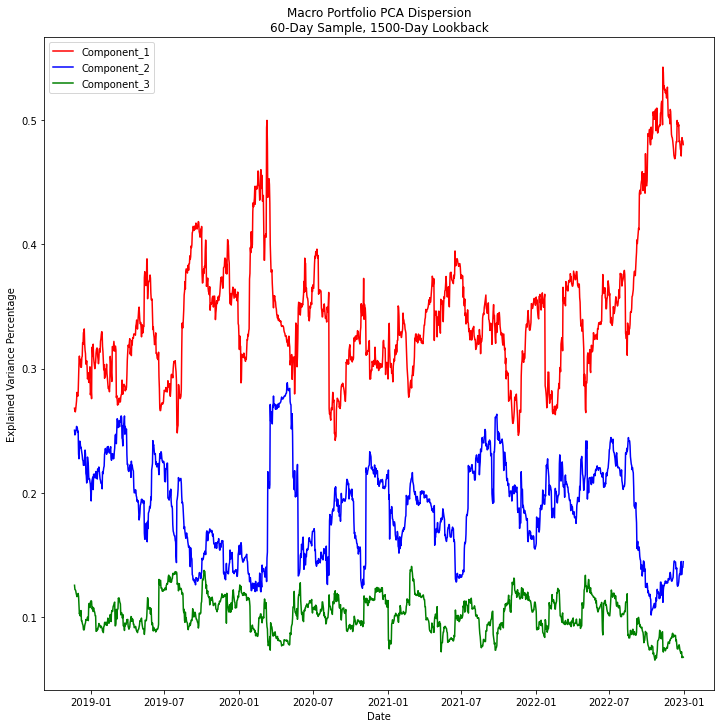

In [253]:
pca_rollingcorr(vector, log_flag, 60, 1500, 360)

In [283]:
vector_2 = ["USOSFRC CURNCY", "USOSFRF CURNCY", "USGG2Y INDEX", "USGG10Y INDEX", "USGG30Y INDEX",]
log_flag_2 = [False, False, False, False, False]



    USOSFRC CURNCY  USOSFRF CURNCY  USGG2Y INDEX  USGG10Y INDEX  USGG30Y INDEX
0         0.667701        0.616717      0.851172      -0.024710      -0.924606
1         0.564150       -0.122791      1.021096       0.804983       0.725992
2         0.978353        1.812190      1.276650       0.648049       0.617868
3        -1.265244       -1.444709     -0.723629       0.199114       0.951820
4         0.805768        0.873437      0.864552       0.759961       1.055837
5        -0.505873       -0.812487     -0.933692      -1.107813      -0.542751
6         1.420169        0.145424     -0.933692      -0.348869      -0.028137
7        -2.714953       -2.674667     -3.292549      -3.548010      -2.917366
8        -0.775105       -0.141949      0.017612       0.051185      -0.425047
9         0.253498       -0.015505      0.776246       0.579873       0.345506
10       -0.057154       -0.647726     -0.659406      -1.029346      -0.972509
11        0.888609        0.413640      0.241054    

,Comp1,Comp2,Comp3
USOSFRC CURNCY,0.380000,0.630000,-0.630000
USOSFRF CURNCY,0.430000,0.470000,0.490000
USGG2Y INDEX,0.490000,-0.100000,0.460000
USGG10Y INDEX,0.480000,-0.380000,-0.050000
USGG30Y INDEX,0.440000,-0.480000,-0.400000


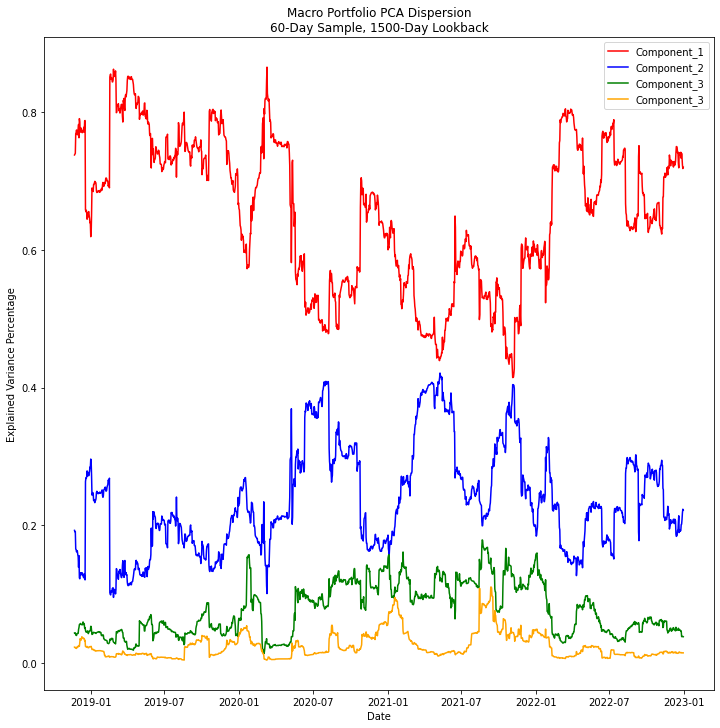

In [292]:
pca_rollingcorr(vector_2, log_flag_2, 60, 1500, 360)



In [293]:

vector_bd = ["NZDCAD CURNCY", "GBPJPY CURNCY", "GBPAUD CURNCY", "USDJPY CURNCY", "AUDCAD CURNCY", "GBPCHF CURNCY",
            "AUDUSD CURNCY", "NZDUSD CURNCY", "CL1 COMDTY", "ES1 INDEX", "NQ1 INDEX",
            "TSLA EQUITY", "EURGBP CURNCY", "USDCNH CURNCY", "MSTR EQUITY", "XBTUSD CURNCY", "XETUSD CURNCY"]
log_flag_bd = [True, True, True, True, True, True,
              True, True, True, True, True, True,
              True, True, True, True, True]


,Comp1,Comp2,Comp3,Comp4
NZDCAD CURNCY,0.280000,-0.130000,-0.330000,-0.080000
GBPJPY CURNCY,0.270000,-0.370000,0.180000,0.150000
GBPAUD CURNCY,-0.120000,-0.480000,0.150000,-0.010000
USDJPY CURNCY,0.040000,0.090000,0.340000,0.330000
AUDCAD CURNCY,0.320000,-0.060000,-0.330000,-0.140000
GBPCHF CURNCY,0.180000,-0.430000,0.230000,0.000000
AUDUSD CURNCY,0.400000,0.080000,-0.190000,-0.020000
NZDUSD CURNCY,0.390000,0.020000,-0.230000,-0.010000
CL1 COMDTY,-0.060000,0.230000,0.230000,0.020000
ES1 INDEX,0.310000,0.190000,0.310000,0.090000


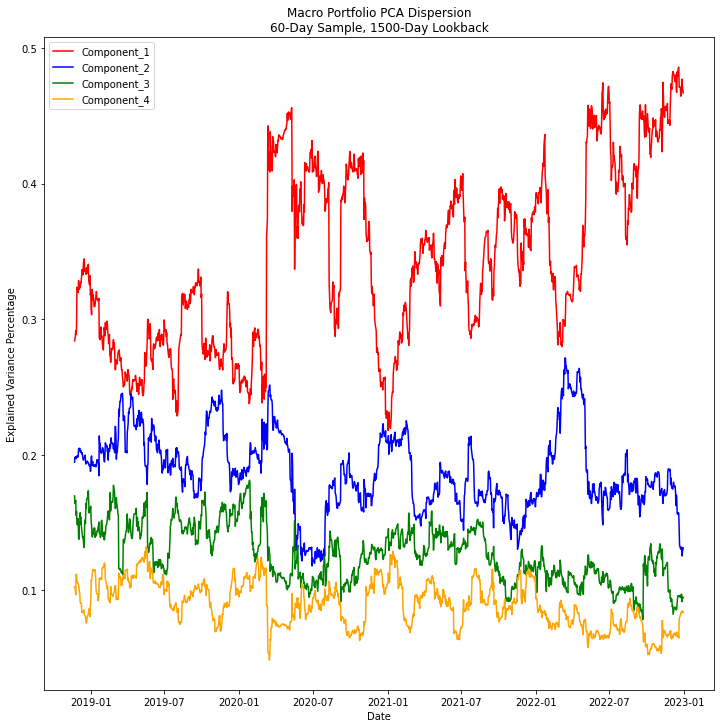

In [299]:
pca_rollingcorr(vector_bd, log_flag_bd, 60, 1500, 360)